In [15]:
from __future__ import print_function
from __future__ import division
import os
import sys
import io
import cntk
import cntk.ops
import cntk.io
import cntk.train
import pandas as pd
import numpy as np
import random
import math
from scipy import sparse as sp
import cntk.tests.test_utils
from cntk.io import MinibatchSource
from cntk.io import UserDeserializer

%matplotlib inline

cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
# cntk.cntk_py.set_fixed_random_seed(1) # fix the random seed so that LR examples are repeatable

In [16]:
import os
from cntk import NDArrayView
from scipy.misc import imread
import matplotlib.pyplot as plt
import time
import h5py

myFile = "E:/TCC/Datasets/ucf101_of_train.h5py"

In [36]:
### Image transforms ###
def random_crop(img, size=224):
    h, w, _ = img.shape
    if (h<size) or (w<size):
        raise ValueError("Image shape: (%d, %d) but crop size: %d"%(h, w, size))
    hh = np.random.randint(h-size)
    ww = np.random.randint(w-size)
    return img[hh:hh+size, ww:ww+size, :]

def horizontal_flip(img):
    return img[:, ::-1, :]


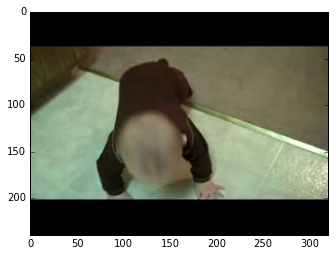

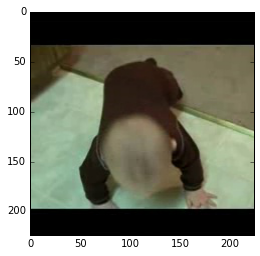

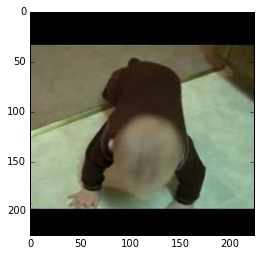

In [45]:
### Testing transforms ###
img_path = "E:/TCC/Datasets/UCF-101_rgb/BabyCrawling/v_BabyCrawling_g01_c04.avi/4.jpg"
img = imread(img_path)

img_c = random_crop(img)

img_f = horizontal_flip(img_c)

plt.imshow(img)
plt.show()
plt.imshow(img_c)
plt.show()
plt.imshow(img_f)
plt.show()

In [50]:
with h5py.File(myFile, 'r') as f:
    print(f["labels"].shape[0])

4


In [14]:
class OFDeserializer(UserDeserializer):
    def __init__(self, filename, chunksize = 20*224*224*20):
        super(OFDeserializer, self).__init__()
        self._chunksize = chunksize
        self._filename = filename
        
        # Create the information about streams based on the user provided data
        self._streams = [cntk.io.StreamInformation('image', 0, 'dense', np.float32, shape=(20,224,224,)),
                         cntk.io.StreamInformation('label', 1, 'sparse', np.float32, shape=(101,))]
        
        with h5py.File(self._filename, 'r') as f:
            self._num_chunks = f["labels"].shape[0]
        # Define the number of chunks based on the file size
#         blockImgSize = 20*224*224*4
#         self._imgs_per_chunk = int(math.floor(chunksize/blockImgSize))
#         self._num_chunks = int(math.ceil((len(self.stackPaths)/self._imgs_per_chunk)))
        
    def stream_infos(self):
        return self._streams

    def num_chunks(self):
        return self._num_chunks

    # Ok, let's actually get the work done
    def get_chunk(self, chunk_id):        
        actual_id = chunk_id*self._imgs_per_chunk
        first_paths = self.stackPaths[actual_id:min(actual_id+self._imgs_per_chunk, len(self.stackPaths))]
        video_array = []
        label_array = []
        zip_u = None
        zip_v = None
        pieces = first_paths[0].split('@')
        if len(pieces)>1:
            zip_path = pieces[0].split('\t')[-1]
            start_time = time.time()
            zip_u = zipfile.ZipFile(zip_path, 'r')
            zip_v = zipfile.ZipFile(zip_path.replace('u.zip', 'v.zip'), 'r')
            print('---- %gs ----' %(time.time()-start_time))
        
        
        for p in first_paths:
            p = p.split('@'+os.sep)[-1]
            pieces = p.split('\t')
            path = pieces[-2]
            label = int(pieces[-1])
            base_path, frame = path.split('frame')
            frame_init = int(frame.split('.')[0])
            
            stack_array = []
            # 10 frames in the stack
            for i in range(frame_init, frame_init+10):
                full_u_path = os.path.join(base_path, 'frame{0:06d}.jpg'.format(i))
                full_v_path = full_u_path.replace('u'+os.sep, 'v'+os.sep)
#                 print(full_u_path, full_v_path)
                if zip_u is None:  
                    img_u = Image.open(full_u_path)
                    img_v = Image.open(full_v_path)
                else:
                    img_u = Image.open(zip_u.open(full_u_path.replace(os.sep, '/')))
                    img_v = Image.open(zip_v.open(full_v_path.replace(os.sep, '/')))
                    
                u = img_u.crop((0, 0, 224, 224))
                v = img_v.crop((0, 0, 224, 224))
                new_u = np.asarray(u, dtype=np.float32)
                new_v = np.asarray(v, dtype=np.float32)
                stack_array.append(new_u)
                stack_array.append(new_v)
            video_array.append(stack_array)
            target = [0.0]*101
            target[int(label)] = 1.0
            label_array.append(target)
        
        if zip_u is not None:
            zip_u.close()
            zip_v.close()
        
        result = {}
        result[self._streams[0].m_name] = np.ascontiguousarray(video_array)
        result[self._streams[1].m_name] = sp.csr_matrix(label_array, dtype=np.float32)
        return result


In [15]:
d = CSVDeserializer(filename=myFile)

mbs = MinibatchSource([d], randomize=True, max_samples=2560)

In [ ]:
# d.get_chunk(810000)
mb = mbs.next_minibatch(10)
# print(mb['label'])

In [ ]:
# d.get_chunk(168605)


In [ ]:
total_num_samples = 0
start = time.time()
while True:
    mb = mbs.next_minibatch(256)
    if not mb:
        break
    total_num_samples += mb[mbs.streams.label].number_of_samples
    if total_num_samples % 256 == 0:
        sys.stdout.write('.')
end = time.time()
print()
print('Total number of samples %d, speed %f samples per second' % (total_num_samples, total_num_samples/(end-start)))

---- 84.1929s ----
---- 79.663s ----
---- 83.45s ----
---- 80.6243s ----
---- 92.8677s ----
---- 89.2598s ----
---- 91.1348s ----
---- 92.4935s ----
---- 88.8806s ----
---- 90.8252s ----
---- 89.6386s ----
---- 90.9559s ----
---- 90.4424s ----
---- 92.0251s ----
---- 91.0946s ----
---- 88.9886s ----
---- 91.1784s ----
---- 90.3052s ----
---- 89.8065s ----
---- 91.9008s ----
---- 89.2924s ----
---- 91.1364s ----
---- 92.3396s ----
---- 88.9336s ----
---- 90.8011s ----
---- 90.6104s ----
---- 91.3245s ----
---- 91.7622s ----
---- 89.356s ----
---- 92.1623s ----
---- 90.4654s ----
---- 89.8716s ----
---- 88.9655s ----


In [12]:
total_num_samples = 0
start = time.time()
while True:
    mb = mbs.next_minibatch(256)
    if not mb:
        break
    total_num_samples += mb[mbs.streams.label].number_of_samples
    if total_num_samples % 256 == 0:
        sys.stdout.write('.')
end = time.time()
print()
print('Total number of samples %d, speed %f samples per second' % (total_num_samples, total_num_samples/(end-start)))

..........
Total number of samples 2560, speed 12.135996 samples per second


In [ ]:

label_array = mb[mbs.streams['label']].data.asarray()

labels = np.squeeze(np.argmax(label_array, axis=-1))
labels, count = np.unique(labels, return_counts=True)
print(labels, count)

Now let's read through the data using the corresponding minibatch source:

In [36]:
mb2 = mbs.next_minibatch(10)
label_array = mb[mbs.streams['label']].data.asarray()

labels = np.squeeze(np.argmax(label_array, axis=-1))
labels, count = np.unique(labels, return_counts=True)
print(labels, count)

[0 1 2 3] [4 2 2 2]


C:\CNTK\bindings\python\cntk\tensor.py:236: UserWarning: converting Value object to CSR format might be slow
  warnings.warn('converting Value object to CSR format might be slow')
C:\CNTK\bindings\python\cntk\tensor.py:244: UserWarning: Cannot convert a sparse NDArrayView or Value object with shape (10, 1, 101) of rank > 2 to a scipy.csr matrix. Returning dense data.
  ' Returning dense data.' % str(dense_data.shape))


In [12]:
d = CSVDeserializer(filename=filename, streams=[dict(name='x', shape=(150,)), dict(name='y', shape=(1,))], chunksize=32*1024)
mbs = MinibatchSource([d], randomize=True, max_sweeps=1)

mb = mbs.next_minibatch(128)
print(mb[mbs.streams.x].data.asarray())

Getting chunk 4839
Getting chunk 4134
Getting chunk 265
Getting chunk 3723
Getting chunk 1064
Getting chunk 5770
Getting chunk 97
Getting chunk 7745
Getting chunk 9617
Getting chunk 2253
Getting chunk 5073
Getting chunk 5804
Getting chunk 2791
Getting chunk 5620
Getting chunk 7554
Getting chunk 8633
Getting chunk 1600
Getting chunk 3476
Getting chunk 740
Getting chunk 4025
Getting chunk 2513
Getting chunk 2463
Getting chunk 444
Getting chunk 9354
Getting chunk 8461
Getting chunk 8930
Getting chunk 8510
Getting chunk 396
Getting chunk 254
Getting chunk 3925
Getting chunk 8437
Getting chunk 6113
Getting chunk 2251
Getting chunk 1509
Getting chunk 2919
Getting chunk 682
Getting chunk 2598
Getting chunk 2705
Getting chunk 6572
Getting chunk 3174
Getting chunk 6217
Getting chunk 3486
Getting chunk 4379
Getting chunk 4258
Getting chunk 7524
Getting chunk 1437
Getting chunk 840
Getting chunk 5541
Getting chunk 7786
Getting chunk 1567
Getting chunk 2869
Getting chunk 990
Getting chunk 8218
Get

In [24]:
import time

d = CSVDeserializer(filename=filename, streams=[dict(name='x', shape=(150,)), dict(name='y', shape=(1,))])
mbs = MinibatchSource([d], randomize=False, max_sweeps=1)

total_num_samples = 0
start = time.time()
while True:
    mb = mbs.next_minibatch(128)
    if not mb:
        break
    total_num_samples += mb[mbs.streams.x].number_of_samples
    if total_num_samples % 12800 == 0:
        sys.stdout.write('.')
end = time.time()
print()
print('Total number of samples %d, speed %f samples per second' % (total_num_samples, total_num_samples/(end-start)))

...............
Total number of samples 200000, speed 23691.068044 samples per second


## 3. Randomization

The randomization is enabled simply by instantiating the [MinibatchSource](https://cntk.ai/pythondocs/cntk.io.html?#cntk.io.MinibatchSource) with _randomize=True_. Randomization happens each sweep and is two-fold: firstly all chunks are randomized, then the window of chunks is created (controlled using `randomization_window_in_chunks` or `randomization_window_in_samples` parameters) and all sequences inside the window are randomized in their own turn.

## 4. Checkpointing

Checkpointing is done transparently for the deserializer. You can use [get_checkpoint_state](https://cntk.ai/pythondocs/_modules/cntk/io.html#MinibatchSource.get_checkpoint_state) and [restore_from_checkpoint](https://cntk.ai/pythondocs/_modules/cntk/io.html#MinibatchSource.restore_from_checkpoint) on the [MinibatchSource](https://cntk.ai/pythondocs/cntk.io.html?#cntk.io.MinibatchSource).

## 5. Distribution

Distribution is done transparently for the deserializer. In case of randomization, the distribution is based on the chunk id, in non randomized mode - on the sequence position in the sweep.

## 6. Threading

__get_chunk__ is executed on the prefetch thread.
Please be aware that [real multithreading is not possible in CPython](https://docs.python.org/3.6/library/threading.html): 
> _In CPython, due to the Global Interpreter Lock, only one thread can execute Python code at once (even though certain performance-oriented libraries might overcome this limitation). If you want your application to make better use of the computational resources of multi-core machines, you are advised to use multiprocessing or concurrent.futures.ProcessPoolExecutor. However, threading is still an appropriate model if you want to run multiple I/O-bound tasks simultaneously._

